# Hawaii climate analysis

### Set-up

In [59]:
# Style
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [60]:
# Dependencies
import numpy as np
import pandas as pd
import datetime as dt
from scipy import stats

In [61]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect, extract

In [62]:
# Create engine object
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [63]:
# Reflect an existing database into a new model
Base = automap_base()
# Reflect the tables
Base.prepare(engine, reflect=True)

In [64]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [65]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [66]:
# Createsession from python to the database
session = Session(engine)

### Queries

### Precipitation Analysis

In [67]:
# Examine measurement table
inspector = inspect(engine)
columns = inspector.get_columns('measurement')
for column in columns:
    print(column["name"], column["type"])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [68]:
# Find most recent date
end_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()
print(end_date)

# Find one year timeframe
start_date = dt.datetime(2017, 8, 23) - dt.timedelta(days=365)
print(start_date)

('2017-08-23',)
2016-08-23 00:00:00


In [69]:
# Query the last 12 months of precipitation data
query = session.query(Measurement.date,Measurement.prcp)\
    .filter(Measurement.date > start_date).order_by(Measurement.date).all()

# Save the query results as a Pandas DataFrame and set the index to the date column
df = pd.DataFrame(query, columns=['date', 'precip'])

# Drop NaNs
df = df.dropna()
df.set_index('date')
df['date'] = pd.to_datetime(df.date)
df['date'] = df['date'].dt.strftime('%#m/%#d/%Y')
df

,date,precip
0,8/24/2016,0.08
1,8/24/2016,2.15
2,8/24/2016,2.28
4,8/24/2016,1.22
5,8/24/2016,2.15
...,...,...
2218,8/22/2017,0.50
2219,8/23/2017,0.00
2220,8/23/2017,0.00
2221,8/23/2017,0.08


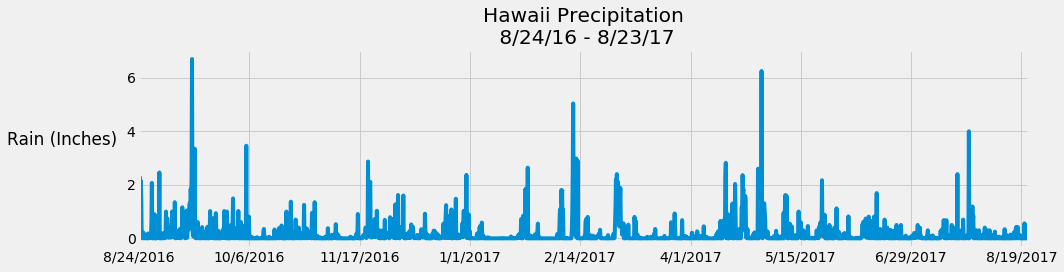

In [70]:
# Plot precipitation results
df.plot('date', 'precip',legend=None,figsize=(15,4))
plt.ylabel("Rain (Inches) ",rotation=0,ha='right')
plt.title("Hawaii Precipitation\n 8/24/16 - 8/23/17")
plt.xlabel("")
plt.xticks(rotation=0)

plt.tight_layout()

plt.show()


In [71]:
# Use Pandas to calcualte the summary statistics for the precipitation data
df.describe()

,precip
count,2015.000000
mean,0.176462
std,0.460288
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


### Station Analysis

In [72]:
# Examine station table
inspector = inspect(engine)
columns = inspector.get_columns('station')
for column in columns:
    print(column["name"], column["type"])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


In [73]:
# Query number of stations
query = session.query(func.count(func.distinct(Station.id))).scalar()
print (f"There are {query} stations in the full data set.")

There are 9 stations in the full data set.


In [74]:
# Query the most active stations and their observation counts in descending order
query = session.query(Measurement.station, func.count(Measurement.tobs)).\
    group_by(Measurement.station).order_by(func.count(Measurement.tobs).desc()).all()
query  

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [75]:
# Using the most active station from the previous query, calculate the lowest temperature recorded, 
    # highest temperature recorded, and average temperature of the most active station
name = session.query(Station.name).filter(Station.station=='USC00519281').all()
print(name)

mtobs = Measurement.tobs
query = session.query(func.min(mtobs),func.max(mtobs),func.avg(mtobs)).\
    filter(Measurement.station=='USC00519281').filter(Measurement.date).all()
query

[('WAIHEE 837.5, HI US',)]


[(54.0, 85.0, 71.66378066378067)]

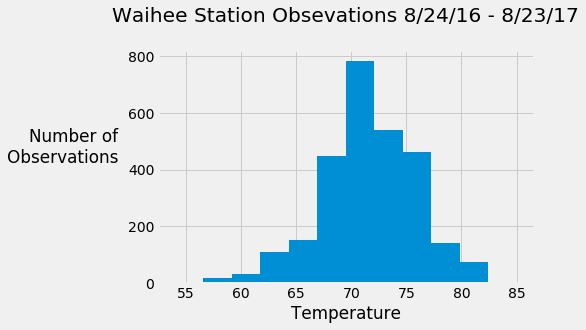

In [92]:
# Using the station with the highest number of temperature observations,
    # query the last 12 months of temperature observation data for this station
query = session.query(Measurement.tobs).\
    filter(Measurement.station=='USC00519281').all()

# Plot the results as a histogram
df2=pd.DataFrame(query)
plt.hist(df2['tobs'],12)
plt.xlabel("Temperature")
plt.ylabel("Number of \nObservations ",rotation=0,ha="right")
plt.title("Waihee Station Obsevations 8/24/16 - 8/23/17\n")
plt.show()


In [77]:
# Flask API created to display JSON respones to climate queries

## Optional Challenges

### Temperature Analysis I

In [78]:
# Query and test if there is a meaningful difference between the temperatures in June vs. December
query1 = session.query(func.avg(Measurement.tobs)).\
        filter(extract('month', Measurement.date)==6).all()
display(query1)

query2 = session.query(func.avg(Measurement.tobs)).\
    filter(extract('month', Measurement.date)==12).all()
display(query2) 

[(74.94411764705882)]

[(71.04152933421226)]

In [79]:
# Use the t-test to determine whether the difference in the means is statistically significant. 
query1 = session.query(Measurement.tobs).\
        filter(extract('month', Measurement.date)==6).group_by(Measurement.station).all()

query2 = session.query(Measurement.tobs).\
    filter(extract('month', Measurement.date)==12).group_by(Measurement.station).all()

# Null hypothesis is that temperature in Hawaii in December is the same as weather in June. 
# The two groups are related, both observations of weather at the same set of locations at different times.
# A Paired sample t-test is used. 
(t_stat, p) = stats.ttest_rel(query1,query2,nan_policy='omit')

print("p is {}.".format(p[0]))
if p < 0.05:
    print("The difference in sample means is significant.")
else:
    print("The difference in sample means is not significant.")

p is 0.4553663435526901.
The difference in sample means is not significant.


### Temperature Analysis II

In [80]:
# Function `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
    # and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.max(Measurement.tobs),func.avg(Measurement.tobs),).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

In [81]:
# Usage of `calc_temps` to calculate the tmin, tavg, and tmax
    # using most recent data for planned trip dates
print(calc_temps('2016-12-01','2016-12-10'))

[(67.0, 77.0, 71.29230769230769)]


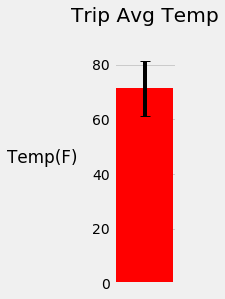

In [82]:
# Plot query as a bar chart with error bar. 
fig, ax = plt.subplots(figsize=(1,4))
ax.bar(1, 71.3, yerr=(77.0-67.0),align='center', color='red', ecolor='black', capsize=5)
plt.title('Trip Avg Temp\n')
plt.ylabel('Temp(F)  ', rotation=0, ha='right')
ax.xaxis.set_visible(False)

### Daily Rainfall Average

In [83]:
# Query the total amount of rainfall per weather station for trip dates using the previous year's matching 
    # dates and sort in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation
start_date = dt.datetime(2016,12,1) 
end_date = dt.datetime(2016,12,10)

query = session.query(Measurement.station, Station.name, Station.latitude, Station.longitude, Station.elevation, func.sum(Measurement.prcp)).\
    filter(Measurement.station == Station.station).\
    filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).\
    group_by(Measurement.station).\
    order_by(func.sum(Measurement.prcp).desc()).all()

query 

[('USC00516128',
  'MANOA LYON ARBO 785.2, HI US',
  21.3331,
  -157.8025,
  152.4,
  5.3100000000000005),
 ('USC00519281',
  'WAIHEE 837.5, HI US',
  21.45167,
  -157.84888999999998,
  32.9,
  1.9000000000000001),
 ('USC00513117', 'KANEOHE 838.1, HI US', 21.4234, -157.8015, 14.6, 1.36),
 ('USC00514830',
  'KUALOA RANCH HEADQUARTERS 886.9, HI US',
  21.5213,
  -157.8374,
  7.0,
  1.1400000000000001),
 ('USC00519397', 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0, 1.11),
 ('USC00519523',
  'WAIMANALO EXPERIMENTAL FARM, HI US',
  21.33556,
  -157.71139,
  19.5,
  0.8800000000000001),
 ('USC00517948', 'PEARL CITY, HI US', 21.3934, -157.9751, 11.9, 0.27)]

In [84]:
# Function that will calculate the daily normals: 
# The averages for tmin, tmax, and tavg for all historic data matching a specific month and day

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.max(Measurement.tobs), func.avg(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 77.0, 69.15384615384616)]

In [85]:
# Analyze weather during a hypothetical vacation
start_date = dt.datetime(2016,12,1)
length = 10
date_list =[]

# Generate list of dates in format that works with daily_normals function
for x in range (0,length):
    date_list.append(f"{start_date.month}-{'{:02}'.format(start_date.day)}")
    start_date += dt.timedelta(days=1)
print(date_list)

# Run dates through daily_normals function
normals=[]
for date in date_list:
    normals.append(daily_normals(date))

# Transform daily_normals function produced list into format for dataframe
normals1 = [i[0]for i in normals]
print(normals1)

['12-01', '12-02', '12-03', '12-04', '12-05', '12-06', '12-07', '12-08', '12-09', '12-10']
[(65.0, 78.0, 71.91666666666667), (62.0, 77.0, 71.32692307692308), (67.0, 79.0, 72.88679245283019), (66.0, 81.0, 72.17647058823529), (64.0, 78.0, 70.92156862745098), (61.0, 78.0, 69.3921568627451), (58.0, 79.0, 69.2), (60.0, 83.0, 70.27450980392157), (64.0, 80.0, 71.90196078431373), (61.0, 78.0, 71.24528301886792)]


In [86]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index
df1 = pd.DataFrame.from_records(normals1,columns=['min','max','avg'])
df1['dates']=date_list
df1.head()

,min,max,avg,dates
0,65.0,78.0,71.916667,12-01
1,62.0,77.0,71.326923,12-02
2,67.0,79.0,72.886792,12-03
3,66.0,81.0,72.176471,12-04
4,64.0,78.0,70.921569,12-05


Text(8.9, 65.8, 'Avg')

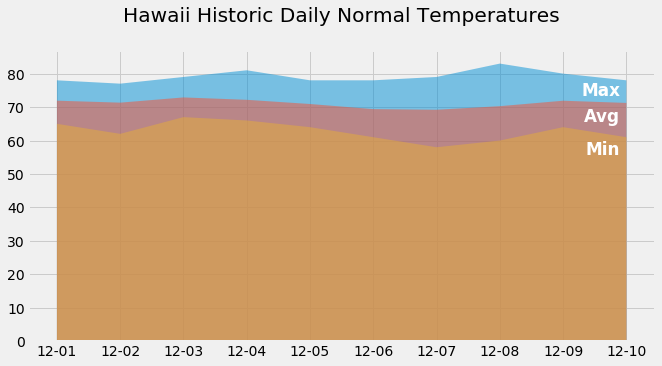

In [100]:
# Plot the daily normals as an area plot with `stacked=False`
fig, ax = plt.subplots(figsize=(10,5))
ax1 = plt.stackplot(df1['dates'],df1['max'],alpha=.5)
ax2 = plt.stackplot(df1['dates'],df1['avg'],alpha=.5)
ax3 = plt.stackplot(df1['dates'],df1['min'],alpha=.5)
plt.title('Hawaii Historic Daily Normal Temperatures\n')
ax.annotate('Min',(8.9,55.9),ha='right',color='white',weight='bold',clip_on=True,size='large')
ax.annotate('Max',(8.9,73.6),ha='right',color='white',weight='bold',clip_on=True,size='large')
ax.annotate('Avg',(8.9,65.8),ha='right',color='white',weight='bold',clip_on=True,size='large')
